In [32]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("Courses.csv")

In [33]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("Courses.csv")

# 1. Remove specified columns
columns_to_remove = ['nplay_video', 'incomplete_flag', 'roles']
df_cleaned = df.drop(columns=columns_to_remove)

# 2. Handle missing values
# For categorical variables (LoE_DI) - impute with mode
df_cleaned['LoE_DI'] = df_cleaned['LoE_DI'].fillna(df_cleaned['LoE_DI'].mode()[0])

# For gender in random way
missing_indices = df_cleaned[df_cleaned['gender'].isnull()].index
df_cleaned.loc[missing_indices, 'gender'] = np.random.choice(df_cleaned['gender'].dropna(), len(missing_indices))

# For YoB - impute with median
df_cleaned['YoB'] = df_cleaned['YoB'].fillna(df_cleaned['YoB'].median())

# 3. Drop rows with missing grades
df_cleaned = df_cleaned.dropna(subset=['grade'])

# 5. Define function for nchapters imputation
def impute_nchapters_simple(df):
    # Create copy of original nchapters
    df['nchapters_imputed'] = df['nchapters'].copy()
    
    # Imputation logic based on certification and activity days
    mask = df['nchapters'].isna()
    
    conditions = [
        # Condition 1: Certified students
        (mask) & (df['certified'] == 1),
        # Condition 2: Not certified but active (ndays_act > 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] > 3),
        # Condition 3: Not certified and some activity (ndays_act <= 3)
        (mask) & (df['certified'] == 0) & (df['ndays_act'] <= 3),
        # Condition 4: No activity recorded (ndays_act is NaN) but viewed course
        (mask) & (df['ndays_act'].isna()) & (df['viewed'] == 1),
        # Condition 5: No activity and never viewed (complete non-engagement)
        (mask) & (df['ndays_act'].isna()) & (df['viewed'] == 0)
    ]
    
    values = [
        16,  # Average for certified students
        3,   # Average for non-certified active students
        1,   # Minimal engagement
        1,   # Viewed but no sustained activity
        0    # Never engaged with content
    ]
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Apply imputation
    df['nchapters_imputed'] = np.select(conditions, values, df['nchapters_imputed'])
    
    return df['nchapters_imputed']

# Apply nchapters imputation
df_cleaned['nchapters_imputed'] = impute_nchapters_simple(df_cleaned)

# 6. nevents missing data
def impute_nevents(row):
    if pd.isna(row['nevents']):  # Only impute if the value is missing
        if row['nchapters'] == 0:
            return 0
        elif row['nchapters'] == 1:
            return np.random.choice([0, 1], p=[0.7, 0.3])
        elif 2 <= row['nchapters'] <= 5:
            return np.random.choice([0, 1, 2], p=[0.5, 0.3, 0.2])
        elif 6 <= row['nchapters'] <= 12:
            return np.random.choice([1, 2, 3], p=[0.4, 0.4, 0.2])
        else:
            return np.random.choice([2, 3, 4], p=[0.3, 0.4, 0.3])
    else:
        return row['nevents']  # Return original value if not missing

# Set random seed for reproducibility
np.random.seed(42)

# Create new column with imputed values
df_cleaned['nevents_imputed'] = df_cleaned.apply(impute_nevents, axis=1)

# 7. Save the cleaned dataset with all changes
df_cleaned.to_csv('cleaned_dataset.csv', index=False)


In [3]:
import pandas as pd
import numpy as np

# Load the cleaned dataset
df_cleaned = pd.read_csv('cleaned_dataset.csv')

# Convert to numeric and handle NaN values
df_cleaned['viewed'] = pd.to_numeric(df_cleaned['viewed'], errors='coerce').fillna(0).astype(int)
df_cleaned['explored'] = pd.to_numeric(df_cleaned['explored'], errors='coerce').fillna(0).astype(int)
df_cleaned['certified'] = pd.to_numeric(df_cleaned['certified'], errors='coerce').fillna(0).astype(int)
df_cleaned['grade'] = pd.to_numeric(df_cleaned['grade'], errors='coerce').fillna(0)
df_cleaned['nevents_imputed'] = pd.to_numeric(df_cleaned['nevents_imputed'], errors='coerce').fillna(0)
df_cleaned['nchapters_imputed'] = pd.to_numeric(df_cleaned['nchapters_imputed'], errors='coerce').fillna(0)

# Convert ID columns to strings
df_cleaned['userid_DI'] = df_cleaned['userid_DI'].astype(str)
df_cleaned['course_id'] = df_cleaned['course_id'].astype(str)

# Save the updated dataset
df_cleaned.to_csv('cleaned_dataset.csv', index=False)

# Let's analyze the dataset
print("\n=== Dataset Overview ===")
print(f"Number of rows: {len(df_cleaned)}")
print(f"Number of columns: {len(df_cleaned.columns)}")
print("\n=== Data Types ===")
print(df_cleaned.dtypes)

print("\n=== Basic Statistics ===")
print(df_cleaned.describe())

print("\n=== Missing Values ===")
print(df_cleaned.isnull().sum())

print("\n=== Sample of First Few Rows ===")
print(df_cleaned.head())

# Additional analysis for binary columns
binary_cols = ['viewed', 'explored', 'certified']
print("\n=== Binary Columns Distribution ===")
for col in binary_cols:
    print(f"\n{col} value counts:")
    print(df_cleaned[col].value_counts(normalize=True).round(3) * 100, "%")



=== Dataset Overview ===
Number of rows: 592766
Number of columns: 19

=== Data Types ===
course_id             object
userid_DI             object
registered             int64
viewed                 int32
explored               int32
certified              int32
final_cc_cname_DI     object
LoE_DI                object
YoB                  float64
gender                object
grade                float64
start_time_DI         object
last_event_DI         object
nevents              float64
ndays_act            float64
nchapters            float64
nforum_posts           int64
nchapters_imputed    float64
nevents_imputed      float64
dtype: object

=== Basic Statistics ===
       registered         viewed       explored      certified            YoB  \
count    592766.0  592766.000000  592766.000000  592766.000000  592766.000000   
mean          1.0       0.631195       0.065592       0.029838    1985.637746   
std           0.0       0.482481       0.247569       0.170141       8.2543

Loading data...
Data Cleaning and Preparation...

Initial missing values:
course_id                 0
userid_DI                 0
registered                0
viewed                    0
explored                  0
certified                 0
final_cc_cname_DI         0
LoE_DI                    0
YoB                       0
gender                    0
grade                     0
start_time_DI             0
last_event_DI        169903
nevents              188443
ndays_act            156092
nchapters            236771
nforum_posts              0
nchapters_imputed         0
nevents_imputed           0
dtype: int64

Handling datetime columns...
Filled 0 missing last_event values using median duration

Fixed 0 invalid duration values

Final missing values check:
course_id                   0
userid_DI                   0
registered                  0
viewed                      0
explored                    0
certified                   0
final_cc_cname_DI           0
LoE_DI                

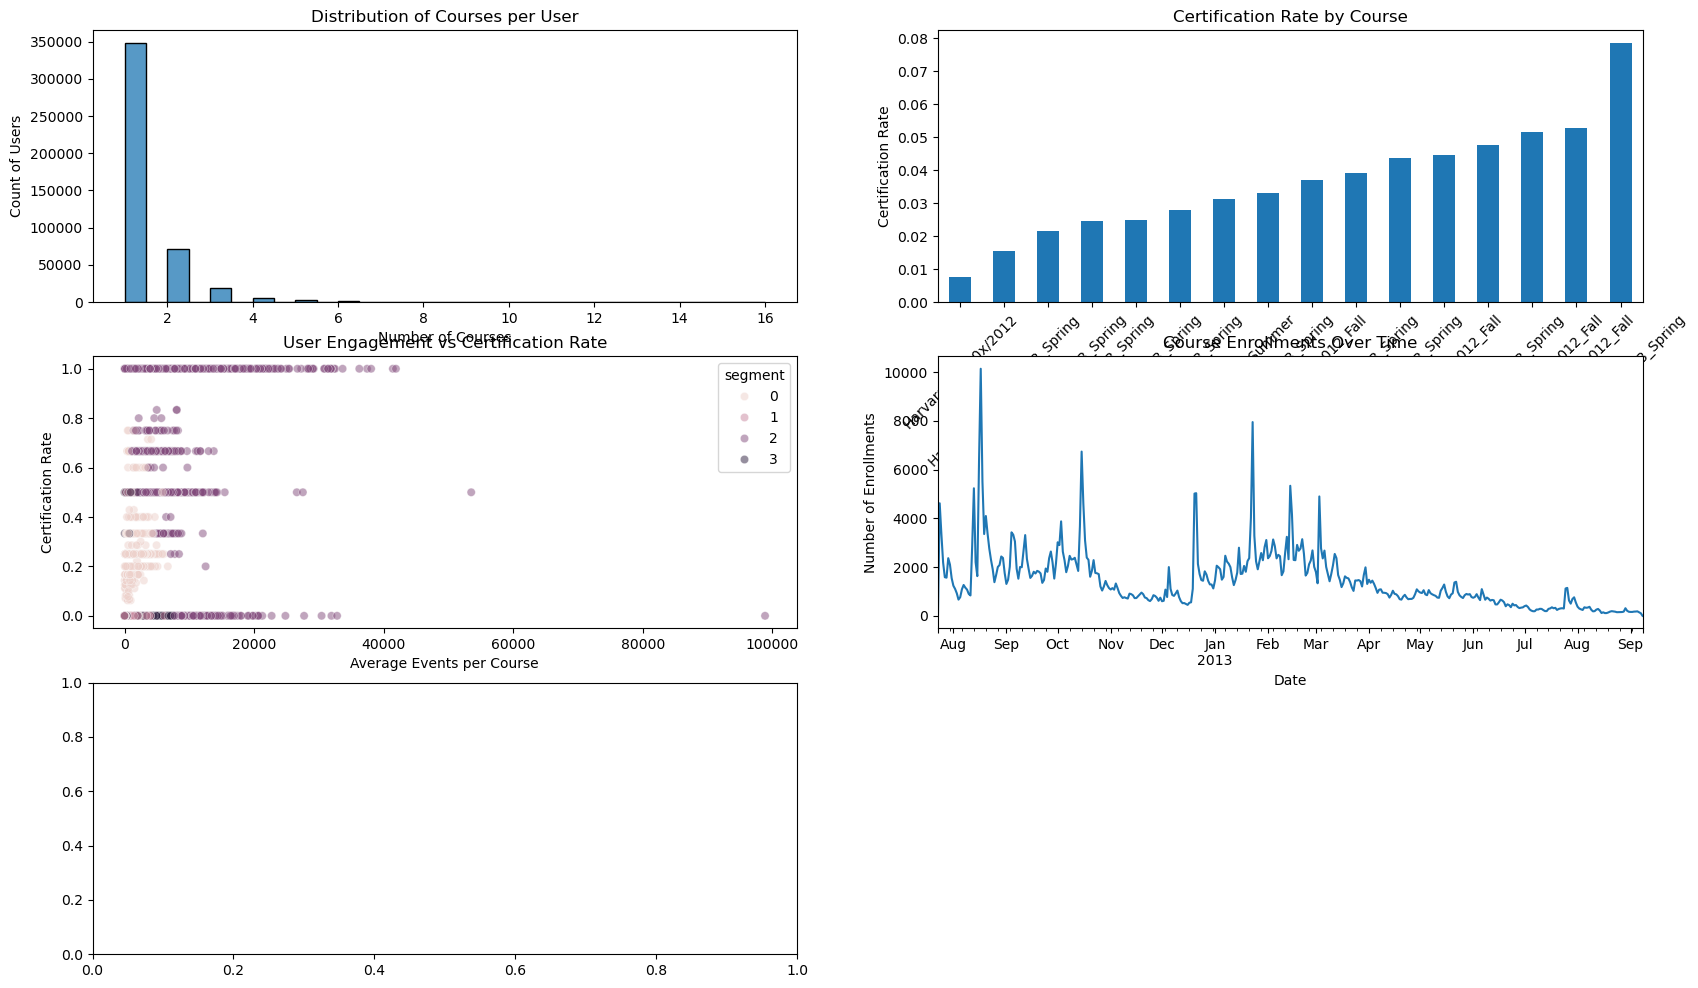

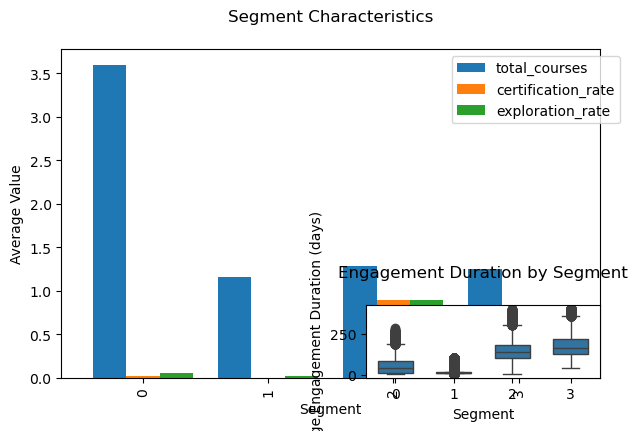

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

def clean_and_prepare_data(df):
    print("Data Cleaning and Preparation...")
    
    # 1. Check initial missing values
    print("\nInitial missing values:")
    print(df.isnull().sum())
    
    # 2. Handle datetime columns
    print("\nHandling datetime columns...")
    df['start_time'] = pd.to_datetime(df['start_time_DI'], errors='coerce')
    df['last_event'] = pd.to_datetime(df['last_event_DI'], errors='coerce')
    
    # 3. Handle missing datetime values
    # For start_time: use the earliest date in the dataset
    if df['start_time'].isnull().any():
        min_date = df['start_time'].min()
        df['start_time'] = df['start_time'].fillna(min_date)
        print(f"Filled {df['start_time'].isnull().sum()} missing start_time values with {min_date}")
    
    # For last_event: use the last known event or start_time + median duration
    if df['last_event'].isnull().any():
        # Calculate median duration for valid entries
        valid_duration = (df['last_event'] - df['start_time']).dropna()
        median_duration = valid_duration.median()
        
        # Fill missing last_event with start_time + median_duration
        df.loc[df['last_event'].isnull(), 'last_event'] = \
            df.loc[df['last_event'].isnull(), 'start_time'] + median_duration
        
        print(f"Filled {df['last_event'].isnull().sum()} missing last_event values using median duration")
    
    # 4. Handle other numerical columns
    numerical_columns = ['nevents_imputed', 'nchapters_imputed', 'viewed', 'explored', 'certified']
    for col in numerical_columns:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"Filled {col} missing values with median: {median_val}")
    
    # 5. Calculate engagement duration
    df['engagement_duration'] = (df['last_event'] - df['start_time']).dt.days
    
    # Handle negative or zero duration (data quality issue)
    if (df['engagement_duration'] <= 0).any():
        median_duration = df[df['engagement_duration'] > 0]['engagement_duration'].median()
        df.loc[df['engagement_duration'] <= 0, 'engagement_duration'] = median_duration
        print(f"\nFixed {(df['engagement_duration'] <= 0).sum()} invalid duration values")
    
    # 6. Final check
    print("\nFinal missing values check:")
    print(df.isnull().sum())
    
    return df

def analyze_user_behavior(df):
    print("\nAnalyzing User Behavior...")
    
    # Basic engagement metrics
    user_behavior = df.groupby('userid_DI').agg({
        'viewed': 'sum',
        'explored': 'sum',
        'certified': 'sum',
        'course_id': 'count',
        'nevents_imputed': 'mean',
        'nchapters_imputed': 'mean',
        'engagement_duration': ['mean', 'max']
    })
    
    # Rename columns for clarity
    user_behavior.columns = [
        'viewed', 'explored', 'certified', 'total_courses',
        'avg_events', 'avg_chapters', 'engagement_duration_mean',
        'engagement_duration_max'
    ]
    
    # Calculate derived metrics
    user_behavior['certification_rate'] = user_behavior['certified'] / user_behavior['total_courses']
    user_behavior['exploration_rate'] = user_behavior['explored'] / user_behavior['total_courses']
    
    print("\nUser Behavior Summary:")
    print(f"Average courses per user: {user_behavior['total_courses'].mean():.2f}")
    print(f"Average certification rate: {user_behavior['certification_rate'].mean():.2%}")
    print(f"Average engagement duration: {user_behavior['engagement_duration_mean'].mean():.2f} days")
    
    return user_behavior

def analyze_courses(df):
    print("\nAnalyzing Course Patterns...")
    
    # Course popularity and completion metrics
    course_metrics = df.groupby('course_id').agg({
        'userid_DI': 'count',
        'certified': 'mean',
        'viewed': 'mean',
        'explored': 'mean',
        'nevents_imputed': 'mean',
        'nchapters_imputed': 'mean',
        'engagement_duration': ['mean', 'median', 'std']
    })
    
    # Rename columns
    course_metrics.columns = [
        'total_enrollments', 'certification_rate', 'view_rate', 'exploration_rate',
        'avg_events', 'avg_chapters', 'avg_duration', 'median_duration', 'duration_std'
    ]
    
    # Course temporal patterns
    course_temporal = df.groupby('course_id').agg({
        'start_time': ['min', 'max', 'count'],
        'engagement_duration': ['mean', 'median']
    })
    
    print("\nCourse Analysis Summary:")
    print(f"Most popular course: {course_metrics['total_enrollments'].idxmax()}")
    print(f"Highest completion rate: {course_metrics['certification_rate'].idxmax()}")
    print(f"Average course duration: {course_metrics['avg_duration'].mean():.2f} days")
    
    return course_metrics, course_temporal

def discover_patterns(df, user_behavior):
    print("\nDiscovering Patterns...")
    
    # Select features for clustering
    features_for_clustering = [
        'total_courses', 'certification_rate', 'avg_events',
        'engagement_duration_mean'
    ]
    
    # Normalize features
    scaler = StandardScaler()
    clustering_data = scaler.fit_transform(user_behavior[features_for_clustering])
    
    # Perform clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    user_segments = kmeans.fit_predict(clustering_data)
    user_behavior['segment'] = user_segments
    
    # Analyze segments
    print("\nUser Segments Summary:")
    segment_summary = user_behavior.groupby('segment').agg({
        'total_courses': 'mean',
        'certification_rate': 'mean',
        'engagement_duration_mean': 'mean'
    })
    
    for segment in range(4):
        print(f"\nSegment {segment}:")
        print(f"Users: {(user_behavior['segment'] == segment).sum()}")
        print(f"Avg courses: {segment_summary.loc[segment, 'total_courses']:.2f}")
        print(f"Avg certification rate: {segment_summary.loc[segment, 'certification_rate']:.2%}")
        print(f"Avg engagement duration: {segment_summary.loc[segment, 'engagement_duration_mean']:.2f} days")
    
    return user_segments

def create_visualizations(df, user_behavior, course_metrics, user_segments):
    print("\nCreating Visualizations...")
    
    #plt.style.use('seaborn')
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Course Enrollment Distribution
    plt.subplot(3, 2, 1)
    sns.histplot(data=user_behavior, x='total_courses', bins=30)
    plt.title('Distribution of Courses per User')
    plt.xlabel('Number of Courses')
    plt.ylabel('Count of Users')
    
    # 2. Certification Rate by Course
    plt.subplot(3, 2, 2)
    course_metrics['certification_rate'].sort_values().plot(kind='bar')
    plt.title('Certification Rate by Course')
    plt.xlabel('Course')
    plt.ylabel('Certification Rate')
    plt.xticks(rotation=45)
    
    # 3. User Engagement Patterns
    plt.subplot(3, 2, 3)
    sns.scatterplot(data=user_behavior, 
                    x='avg_events', 
                    y='certification_rate',
                    hue='segment', 
                    alpha=0.5)
    plt.title('User Engagement vs Certification Rate')
    plt.xlabel('Average Events per Course')
    plt.ylabel('Certification Rate')
    
    # 4. Time Series of Course Enrollments
    plt.subplot(3, 2, 4)
    df.groupby('start_time')['userid_DI'].count().plot()
    plt.title('Course Enrollments Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Enrollments')
    
    # 5. User Segment Characteristics
    plt.subplot(3, 2, 5)
    segment_metrics = user_behavior.groupby('segment').mean()
    ax = segment_metrics[['total_courses', 'certification_rate', 'exploration_rate']].plot(
    kind='bar',
    width=0.8
    )
    plt.title('Segment Characteristics', pad=20)
    plt.xlabel('Segment')
    plt.ylabel('Average Value')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    
    # 6. Engagement Duration Distribution
    plt.subplot(3, 2, 6)
    sns.boxplot(
    data=user_behavior,
    x='segment',
    y='engagement_duration_mean',
    width=0.6
    )
    plt.title('Engagement Duration by Segment', pad=20)
    plt.xlabel('Segment')
    plt.ylabel('Average Engagement Duration (days)')


    plt.tight_layout()
    plt.show()

def main():
    print("Loading data...")
    df = pd.read_csv('cleaned_dataset.csv')
    
    # Clean and prepare data
    df_cleaned = clean_and_prepare_data(df)
    
    print("\nStarting comprehensive analysis...")
    user_behavior = analyze_user_behavior(df_cleaned)
    course_metrics, course_temporal = analyze_courses(df_cleaned)
    user_segments = discover_patterns(df_cleaned, user_behavior)
    
    create_visualizations(df_cleaned, user_behavior, course_metrics, user_segments)
    
    return df_cleaned, user_behavior, course_metrics, user_segments

if __name__ == "__main__":
    df_cleaned, user_behavior, course_metrics, user_segments = main()


In [89]:
# User segmantation recomendation system- Fail 

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

class CourseRecommenderSystem:
    def __init__(self):
        """
        Initialize the Course Recommender System
        """
        self.scaler = StandardScaler()
        self.kmeans = KMeans(n_clusters=4, random_state=42)
        
    def load_data(self, file_path):
        """
        Load and perform initial data validation
        """
        try:
            df = pd.read_csv(file_path)
            print(f"Data loaded successfully. Shape: {df.shape}")
            return df
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return None

    def preprocess_data(self, df):
        """
        Preprocess the data including handling missing values and feature engineering
        """
        print("Starting data preprocessing...")
        
        # 1. Handle datetime columns
        df['start_time'] = pd.to_datetime(df['start_time_DI'], errors='coerce')
        df['last_event'] = pd.to_datetime(df['last_event_DI'], errors='coerce')
        
        # 2. Handle missing last_event values
        median_duration = (df['last_event'] - df['start_time']).dropna().median()
        df.loc[df['last_event'].isnull(), 'last_event'] = df.loc[df['last_event'].isnull(), 'start_time'] + median_duration
        
        # 3. Calculate engagement features
        df['engagement_duration'] = (df['last_event'] - df['start_time']).dt.days
        df['engagement_duration'] = df['engagement_duration'].clip(lower=0)
        
        # 4. Convert and clean numerical columns
        numerical_cols = ['nevents', 'ndays_act', 'nchapters', 'nevents_imputed', 
                         'nchapters_imputed', 'grade', 'certified']
        
        for col in numerical_cols:
            # Convert to numeric, forcing errors to NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Fill NaN with median
            df[col] = df[col].fillna(df[col].median())
        
        # 5. Create user activity features
        try:
            user_activity = df.groupby('userid_DI').agg({
                'course_id': 'count',
                'certified': 'mean',
                'engagement_duration': 'mean',
                'nevents_imputed': 'mean',
                'nchapters_imputed': 'mean',
                'grade': 'mean'
            }).reset_index()
            
            user_activity.columns = ['userid_DI', 'total_courses', 'certification_rate', 
                                   'avg_engagement', 'avg_events', 'avg_chapters', 'avg_grade']
            
            # 6. Validate numerical columns in user_activity
            for col in user_activity.columns:
                if col != 'userid_DI':
                    user_activity[col] = pd.to_numeric(user_activity[col], errors='coerce')
                    user_activity[col] = user_activity[col].fillna(user_activity[col].median())
            
            print("Data preprocessing completed successfully.")
            return df, user_activity
        
        except Exception as e:
            print(f"Error in preprocessing: {str(e)}")
            print("\nColumn types:")
            print(df.dtypes)
            raise

    def create_user_segments(self, user_activity):
        """
        Create user segments based on their behavior
        """
        print("\nCreating user segments...")
        
        # Select features for clustering
        clustering_features = ['total_courses', 'certification_rate', 
                             'avg_engagement', 'avg_events', 'avg_chapters', 'avg_grade']
        
        # Scale features
        X = self.scaler.fit_transform(user_activity[clustering_features])
        
        # Perform clustering
        user_activity['segment'] = self.kmeans.fit_predict(X)
        
        # Print segment statistics
        print("\nSegment Statistics:")
        print(user_activity.groupby('segment').agg({
            'total_courses': 'mean',
            'certification_rate': 'mean',
            'avg_engagement': 'mean',
            'avg_grade': 'mean'
        }).round(2))
        
        return user_activity

    def create_interaction_matrix(self, df):
        """
        Create user-course interaction matrix
        """
        print("\nCreating interaction matrix...")
        
        # Create interaction matrix using grade as interaction strength
        interaction_matrix = df.pivot(
            index='userid_DI', 
            columns='course_id', 
            values='grade'
        ).fillna(0)
        
        print(f"Interaction matrix shape: {interaction_matrix.shape}")
        return interaction_matrix

    def _recommend_for_power_users(self, course_features, taken_courses, n=10):
        """
        Recommend courses for power users based on difficulty and complexity
        """
        available_courses = course_features[~course_features.index.isin(taken_courses)]
        return available_courses.sort_values('nchapters_imputed', ascending=False).index[:n]

    def _recommend_for_casual_users(self, course_features, taken_courses, n=10):
        """
        Recommend courses for casual users based on engagement level
        """
        available_courses = course_features[~course_features.index.isin(taken_courses)]
        return available_courses.sort_values('nevents_imputed', ascending=True).index[:n]

    def _recommend_for_committed_users(self, course_features, taken_courses, n=10):
        """
        Recommend courses for committed users based on certification rate
        """
        available_courses = course_features[~course_features.index.isin(taken_courses)]
        return available_courses.sort_values(['grade', 'certified'], ascending=[False, False]).index[:n]

    def _recommend_for_longterm_users(self, course_features, taken_courses, n=10):
        """
        Recommend courses for long-term browsers based on engagement duration
        """
        available_courses = course_features[~course_features.index.isin(taken_courses)]
        return available_courses.sort_values('ndays_act', ascending=True).index[:n]

    def generate_recommendations(self, user_id, segment, interaction_matrix, course_features, n_recommendations=5):
        """
        Generate course recommendations for a specific user with type handling
        """
        try:
            # Get user's interaction history
            user_history = interaction_matrix.loc[user_id]
            taken_courses = user_history[user_history > 0].index.tolist()
            
            # Convert course features to numeric if needed
            for col in course_features.select_dtypes(include=['object']):
                course_features[col] = pd.to_numeric(course_features[col], errors='coerce')
            
            # Filter courses based on segment
            if segment == 0:  # Power Users
                recommended_courses = self._recommend_for_power_users(course_features, taken_courses)
            elif segment == 1:  # Casual Browsers
                recommended_courses = self._recommend_for_casual_users(course_features, taken_courses)
            elif segment == 2:  # Committed Learners
                recommended_courses = self._recommend_for_committed_users(course_features, taken_courses)
            else:  # Long-term Browsers
                recommended_courses = self._recommend_for_longterm_users(course_features, taken_courses)
            
            # Ensure we return the correct number of recommendations
            recommended_courses = recommended_courses[:n_recommendations].tolist()
            
            # Pad with zeros if we don't have enough recommendations
            while len(recommended_courses) < n_recommendations:
                recommended_courses.append(0)
                
            return recommended_courses
        
        except Exception as e:
            print(f"Error generating recommendations for user {user_id}: {str(e)}")
            return [0] * n_recommendations

    def evaluate_recommendations(self, test_interactions, recommendations):
        """
        Evaluate recommendation quality with proper type handling
        """
        print("\nEvaluating recommendations...")
        
        try:
            # Convert test_interactions to boolean matrix
            test_bool = test_interactions.astype(float) > 0
            
            # Convert recommendations to boolean matrix
            if isinstance(recommendations, pd.DataFrame):
                rec_bool = recommendations.astype(float) > 0
            else:
                rec_bool = pd.DataFrame(recommendations).astype(float) > 0
            
            # Ensure both matrices have the same shape
            common_columns = test_bool.columns.intersection(rec_bool.columns)
            test_bool = test_bool[common_columns]
            rec_bool = rec_bool[common_columns]
            
            # Convert to numpy arrays for sklearn metrics
            test_array = test_bool.values.ravel()
            rec_array = rec_bool.values.ravel()
            
            # Calculate metrics
            precision = precision_score(test_array, rec_array, average='binary', zero_division=0)
            recall = recall_score(test_array, rec_array, average='binary', zero_division=0)
            f1 = f1_score(test_array, rec_array, average='binary', zero_division=0)
            
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1-Score: {f1:.3f}")
            
            return {'precision': precision, 'recall': recall, 'f1': f1}
        
        except Exception as e:
            print(f"Error in evaluation: {str(e)}")
            print("\nDebug information:")
            print(f"Test interactions shape: {test_interactions.shape}")
            print(f"Recommendations shape: {recommendations.shape if hasattr(recommendations, 'shape') else 'N/A'}")
            print(f"Test interactions dtype: {test_interactions.dtypes.value_counts()}")
            print(f"Recommendations dtype: {recommendations.dtypes.value_counts() if isinstance(recommendations, pd.DataFrame) else 'N/A'}")
            return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

def check_data_quality(df):
    """
    Check data quality and print issues
    """
    print("\nData Quality Check:")
    
    # Check for non-numeric values in numeric columns
    numeric_columns = ['nevents', 'ndays_act', 'nchapters', 'nevents_imputed', 
                      'nchapters_imputed', 'grade', 'certified']
    
    for col in numeric_columns:
        if col in df.columns:
            non_numeric = df[pd.to_numeric(df[col], errors='coerce').isna()]
            if len(non_numeric) > 0:
                print(f"\nNon-numeric values found in {col}:")
                print(df[col][pd.to_numeric(df[col], errors='coerce').isna()].value_counts().head())
    
    # Check for extreme values
    print("\nChecking for extreme values:")
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
            if len(outliers) > 0:
                print(f"\nOutliers in {col}:")
                print(f"Number of outliers: {len(outliers)}")
                print(f"Range: [{outliers.min()}, {outliers.max()}]")
    
    return df

def main():
    # 1. Initialize recommender system
    recommender = CourseRecommenderSystem()
    
    # 2. Load data
    df = recommender.load_data('cleaned_dataset.csv') 
    if df is None:
        return
    
    # 3. Check data quality
    df = check_data_quality(df)
    
    # 4. Preprocess data
    df_processed, user_activity = recommender.preprocess_data(df)
    
    # 5. Create user segments
    user_activity = recommender.create_user_segments(user_activity)
    
    # 6. Create interaction matrix and split data
    interaction_matrix = recommender.create_interaction_matrix(df_processed)
    train_matrix, test_matrix = train_test_split(
        interaction_matrix, test_size=0.2, random_state=42)
    
    # Create course features for recommendation
    course_features = df_processed.groupby('course_id').agg({
        'nchapters_imputed': 'mean',
        'nevents_imputed': 'mean',
        'grade': 'mean',
        'certified': 'mean',
        'ndays_act': 'mean'
    })
    
    # 7. Generate and evaluate recommendations for each segment
    results = {}
    for segment in range(4):
        print(f"\nGenerating recommendations for Segment {segment}")
        segment_users = user_activity[user_activity['segment'] == segment]['userid_DI'].values
        
        try:
            # Initialize recommendations matrix
            segment_recommendations = []
            test_users = segment_users[:100]  # Test with 100 users per segment
            
            for user_id in test_users:
                recommendations = recommender.generate_recommendations(
                    user_id, segment, train_matrix, course_features)
                segment_recommendations.append(recommendations)
            
            # Convert recommendations to DataFrame with same columns as test_matrix
            rec_df = pd.DataFrame(
                segment_recommendations,
                index=test_users,
                columns=test_matrix.columns[:len(recommendations)]
            )
            
            # Evaluate segment recommendations
            results[f'Segment_{segment}'] = recommender.evaluate_recommendations(
                test_matrix.loc[test_users], rec_df)
                
        except Exception as e:
            print(f"Error processing segment {segment}: {str(e)}")
            results[f'Segment_{segment}'] = {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    
    # 8. Print final results
    print("\nFinal Results by Segment:")
    for segment, metrics in results.items():
        print(f"\n{segment}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.3f}")

if __name__ == "__main__":
    main()


Data loaded successfully. Shape: (592766, 19)

Data Quality Check:

Non-numeric values found in nevents:
Series([], Name: count, dtype: int64)

Non-numeric values found in ndays_act:
Series([], Name: count, dtype: int64)

Non-numeric values found in nchapters:
Series([], Name: count, dtype: int64)

Non-numeric values found in grade:
grade
    9028
Name: count, dtype: int64

Checking for extreme values:

Outliers in nevents:
Number of outliers: 63877
Range: [419.0, 197757.0]

Outliers in ndays_act:
Number of outliers: 49638
Range: [12.0, 205.0]

Outliers in nchapters:
Number of outliers: 38059
Range: [9.0, 48.0]

Outliers in nevents_imputed:
Number of outliers: 101572
Range: [168.0, 197757.0]

Outliers in nchapters_imputed:
Number of outliers: 93138
Range: [4.0, 48.0]

Outliers in grade:
Number of outliers: 74345
Range: [0.01, 1.01]

Outliers in certified:
Number of outliers: 17687
Range: [1, 1]
Starting data preprocessing...
Data preprocessing completed successfully.

Creating user seg